# QM9 training example

This notebook contains an end-to-end example to train a GAN model on a specific set of molecules and visualize the generated structures. It uses molecules from the QM9 database as training examples and NeuralIL's descriptor generator method.  

If you do not have enough compute available, please check the "QM9 filter example" to use an already trained model.

In [1]:
from besselgan.models import GeneratorModel, CriticModel
from besselgan.training import *
from besselgan.utilities import *
from neuralil.bessel_descriptors import PowerSpectrumGenerator

import optax
import flax.linen as nn

import jax
import jax.numpy as jnp
import numpy as np

from ase import Atoms
from ase.visualize import view
import matplotlib.pyplot as plt

import pickle

We generate rattled versions of all C4H10O and C6H14O isomers as training data.

In [2]:
allatoms = pickle.load(open("QM9_data/train_atoms.pck", "rb"))

N_RATTLE = 20
RATTLESIZE = 0.05

train_formulas = ["C4H10O", "C6H14O"]

train_atoms = []
for atoms in allatoms:
    if atoms.get_chemical_formula() in train_formulas:
        for i in range(N_RATTLE):
            tmp = atoms.copy()
            tmp.rattle(RATTLESIZE)
            train_atoms.append(tmp)

anum_map = make_atomic_number_map(train_atoms)
N_TYPES = len(anum_map)
reverse_anum_map = {}
for elem in anum_map:
    reverse_anum_map[anum_map[elem]] = elem

As descriptors we use the per atom flattened version of NeuralIL's descriptors extended with a one-hot encoding of the atom type.

In [3]:
R_CUT = 5
N_MAX = 4
N_NEIG = 10
descriptor_generator = PowerSpectrumGenerator(N_MAX, R_CUT, N_TYPES, N_NEIG)


@jax.jit
def desc_generator_method(allpos, alltype, pos, types, cell):
    desc = descriptor_generator.process_some_data(allpos, alltype, pos, cell)
    desc = jnp.reshape(desc, (pos.shape[0], -1))
    desc = jnp.append(desc, jax.nn.one_hot(types, N_TYPES), axis=1)

    return desc


training_dict = make_training_dict(train_atoms, desc_generator_method, anum_map)

Define the necessary parameters of the generator and critic models.  
Since the generator (with the postprocessing) generates the atoms in a cell, it has to be specified to a realistic size.  If the cell is too small we are unable to generate realistic structures, if it is too large the training becomes unstable, since if atoms are spread out more than R_CUT far away from eachother the generator gets no gradient information during the training.

The postprocessing step returns with ```np.zeros((3,3))``` unit cell, since that is used to turn off the PBC in the descriptor generation.

In [4]:
SEED = 333
rng = jax.random.PRNGKey(SEED)

N_DIMENSIONS = 3
N_LATENT = 20
TYPES = np.array([6] * 5 + [1] * 12 + [8])
TYPES = np.array([anum_map[t] for t in TYPES])
N_POINTS = len(TYPES)
GEN_CELL = jnp.array([[8.0, 0.0, 0.0], [0.0, 7.0, 0.0], [0.0, 0.0, 6.0]])

GENERATOR_SHAPE = [512, 256, 128, 64, 32]
CRITIC_SHAPE = [256, 128, 64, 32]

N_BATCH = 15
N_CRIT = 5
N_GP_PER_CRIT = 2

LR_CRIT = 10**-3.5
LR_GEN = 10**-3.5


def postprocess(intermediate):
    pos = intermediate.reshape((N_POINTS, N_DIMENSIONS))
    pos = jnp.matmul(pos, GEN_CELL)
    return pos, TYPES, pos, TYPES, jnp.zeros(shape=(3, 3))

In [5]:
generator = GeneratorModel(
    features=GENERATOR_SHAPE,
    n_points=N_POINTS,
    n_dimensions=N_DIMENSIONS,
    n_latent=N_LATENT,
    n_scalars=0,
)

critic = CriticModel(features=CRITIC_SHAPE)

optimizer_gen = optax.rmsprop(LR_GEN)
optimizer_crit = optax.rmsprop(LR_CRIT)

In [6]:
rng, key = jax.random.split(rng)
params_gen = generator.init(key, jax.random.normal(key, shape=(N_LATENT,)))
rng, key = jax.random.split(rng)
params_crit = critic.init(key, training_dict[0][0])

opt_state_gen = optimizer_gen.init(params_gen)
opt_state_crit = optimizer_crit.init(params_crit)

Define the three kinds of training steps:
- generator step (update the ```params_gen``` to decrease the critic predictions on the generated structures)
- critic step (update ```params_crit``` to increase/decrease the critic results on real/generated structures)
- gradient penalty step (update ```params_crit``` to force the gradient of the critic predictions to be close to 1)

In [7]:
train_step_gen = create_generator_step(
    critic=critic,
    generator=generator,
    descriptor_method=desc_generator_method,
    postprocess=postprocess,
    n_batch=N_BATCH,
    optimizer_gen=optimizer_gen,
)

train_step_crit = create_critic_step(
    critic=critic,
    generator=generator,
    descriptor_method=desc_generator_method,
    postprocess=postprocess,
    n_batch=N_BATCH,
    optimizer_crit=optimizer_crit,
)

train_step_gp = create_gradient_penalty_step(
    critic=critic,
    generator=generator,
    descriptor_method=desc_generator_method,
    postprocess=postprocess,
    n_batch=N_BATCH,
    optimizer_crit=optimizer_crit,
)

Utility functions to hide explicit dependence on the critic, postprocessing, etc...

In [8]:
eval_single_desc = create_evaluate_single_descriptor(critic)
eval_batch_desc = create_evaluate_batch_descriptor(critic)

generate_single_desc = create_generate_descriptor(desc_generator_method)
generate_batch_desc = create_generate_batch_descriptor(desc_generator_method)

generate_structures = create_generate_structures(generator, postprocess, N_LATENT)

In [9]:
sampler = make_real_sampler(TYPES, N_BATCH, training_dict)

In [10]:
real_preds = []
fake_preds = []
gen_snapshots = []
crit_snapshots = []

Start the training. Snapshots are taken every 100 iteration.

In [11]:
for i in range(6001):
    if i % 100 == 0:
        rng, key = jax.random.split(rng)
        allpos, alltype, pos, type, cell = generate_structures(params_gen, key, N_BATCH)
        desc = generate_batch_desc(allpos, alltype, pos, type, cell)
        desc = desc.reshape((-1, desc.shape[-1]))

        pred_fake = np.mean(eval_batch_desc(params_crit, desc))
        rng, key = jax.random.split(rng)
        real_desc, rng = sampler(key)
        real_desc = real_desc.reshape((N_BATCH * N_POINTS, -1))
        pred_real = np.mean(eval_batch_desc(params_crit, real_desc))

        real_preds.append(pred_real)
        fake_preds.append(pred_fake)

        print(i, pred_fake, pred_real, pred_fake - pred_real)

        gen_snapshots.append(params_gen)
        crit_snapshots.append(params_crit)

    params_gen, opt_state_gen, rng = train_step_gen(
        params_crit, params_gen, opt_state_gen, rng
    )
    for _ in range(N_CRIT):
        rng, key = jax.random.split(rng)
        real_desc, rng = sampler(key)
        real_desc = real_desc.reshape((N_BATCH * N_POINTS, -1))
        params_crit, opt_state_crit, rng = train_step_crit(
            params_crit, params_gen, opt_state_crit, real_desc, rng
        )
        for _ in range(N_GP_PER_CRIT):
            rng, key = jax.random.split(rng)
            real_desc, rng = sampler(key)
            real_desc = real_desc.reshape((N_BATCH * N_POINTS, -1))
            params_crit, opt_state_crit, rng = train_step_gp(
                params_crit, params_gen, opt_state_crit, real_desc, rng
            )

/home/pkovacs/miniconda3/envs/BesselGAN2/lib/python3.9/site-packages/flax/core/scope.py:600: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/home/pkovacs/miniconda3/envs/BesselGAN2/lib/python3.9/site-packages/flax/core/scope.py:601: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


0 0.28746864 0.017820673 0.26964796
100 0.10874411 -0.12714753 0.23589164
200 0.017198373 -0.19685651 0.21405488
300 -0.013586346 -0.22238506 0.20879872
400 -0.019905536 -0.25945446 0.23954892
500 -0.060112827 -0.25958076 0.19946793
600 -0.020388793 -0.22334433 0.20295553
700 0.023517827 -0.25347427 0.27699208
800 -0.021457147 -0.2246715 0.20321435
900 0.03019281 -0.2212289 0.25142172
1000 0.030005688 -0.1860545 0.21606019
1100 0.03669957 -0.16320284 0.19990242
1200 0.07842283 -0.1523371 0.23075993
1300 0.05091166 -0.13422117 0.18513283
1400 0.06740126 -0.1367238 0.20412506
1500 0.05011554 -0.1367384 0.18685395
1600 0.068716995 -0.14988095 0.21859795
1700 0.06901442 -0.11370674 0.18272117
1800 0.1105556 -0.09770699 0.2082626
1900 0.09954022 -0.08791034 0.18745056
2000 0.085069515 -0.10239292 0.18746243
2100 0.1035714 -0.09279395 0.19636536
2200 0.09670643 -0.0760661 0.17277253
2300 0.12072734 -0.068819866 0.18954721
2400 0.08660121 -0.084512554 0.17111376
2500 0.09877558 -0.08227933 0.

Text(0.5, 0, 'Epoch')

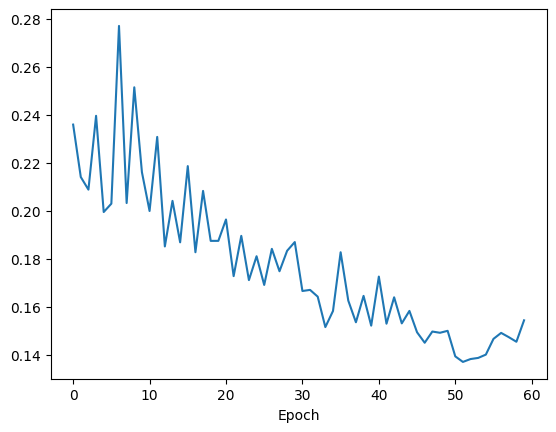

In [12]:
plt.plot(np.array(fake_preds)[1:] - np.array(real_preds)[1:])
plt.xlabel("Epoch")

Generate and visualize a structure. Rerunning the cell results in different structures.

In [13]:
rng, key = jax.random.split(rng)
all_pos, all_type, _, _, _ = generate_structures(params_gen, key, 1)
atom = Atoms(positions=all_pos[0])
atom.center(about=0)
atom.set_atomic_numbers(
    np.array([reverse_anum_map[int(i)] for i in all_type[0]]).flatten()
)
view(atom, viewer="x3d")